#FASHION-MNIST CLOTHING CLASSIFICATION USING CNN AND OPTIMIZE IT USING KERAS TUNER (#1)
##Dataset : Keras

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=733695702fc0ad6efc0d9612b403cc38a458e47814e03e1fa48f4bf6b4fa2918
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=30c5b8c26b868879afe65cf01a228eb62229a28f539b525d1e859be390f819fe
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from tensorflow import keras
import numpy as np
from kerastuner import RandomSearch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Load Data

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

In [ ]:
(X_train,Y_train),(X_test,Y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


#Data pre-processing

##Normalize

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

##Reshape

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train = X_train.reshape(len(X_train),28,28,1)
X_test = X_test.reshape(len(X_test),28,28,1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

#Finding the Best Model

##Building the model

In [ ]:
def build_model(hp):
  #initialising the model
  model = keras.models.Sequential()  

  #CONV1
  model.add(keras.layers.Conv2D(
      filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      kernel_initializer='he_uniform',
      input_shape=(28,28,1)
    )
  )
  
  #CONV2
  model.add(keras.layers.Conv2D(
      filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      kernel_initializer='he_uniform'
    )
  )
  
  #FLATTEN
  model.add(keras.layers.Flatten())

  #FC1
  model.add(keras.layers.Dense(
      units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
      activation='relu',
      kernel_initializer='he_uniform'
    )
  )
  
  model.add(keras.layers.Dense(
      units=10,
      activation='softmax'
    )
  )
    
  #compiling the model
  model.compile(
      optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2,1e-3])),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  
  return model

##HPT using Keras Tuner
###Hyperparameters:
1. Number of filters in CONV layers.
2. Filter size.
3. Number of neurons in hidden layers.
4. Learning rate.

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name="Fashion-MNIST"
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [ ]:
tuner.search(
    x=X_train, 
    y=Y_train,             
    epochs=5,
    batch_size=16,
    validation_split=0.2
)

Trial 5 Complete [00h 02m 55s]
val_accuracy: 0.9083055456479391

Best val_accuracy So Far: 0.9090277751286825
Total elapsed time: 00h 14m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in output/Fashion-MNIST
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
dense_1_units: 112
learning_rate: 0.001
Score: 0.9090277751286825
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 3
dense_1_units: 96
learning_rate: 0.001
Score: 0.9083055456479391
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 3
dense_1_units: 32
learning_rate: 0.001
Score: 0.9058333436648051
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
dense_1_units: 48
learning_rate: 0.001
Score: 0.9044722119967142
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
dense_1_units: 48
learning_rate: 0.01
Score: 0.8316111167271932


In [ ]:
model_best = tuner.get_best_models(num_models=1)[0]

In [ ]:
model_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
flatten (Flatten)            (None, 55296)             0         
_________________________________________________________________
dense (Dense)                (None, 112)               6193264   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1130      
Total params: 6,278,394
Trainable params: 6,278,394
Non-trainable params: 0
_________________________________________________________________


#Training Phase

In [ ]:
model_best_history = model_best.fit(
    x=X_train,
    y=Y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.2,
    initial_epoch=5
)

Epoch 6/15
3000/3000 [==============================] - 14s 4ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.4790 - val_accuracy: 0.9088
Epoch 7/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.5799 - val_accuracy: 0.9064
Epoch 8/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.5704 - val_accuracy: 0.9078
Epoch 9/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.6098 - val_accuracy: 0.9023
Epoch 10/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0187 - accuracy: 0.9939 - val_loss: 0.8383 - val_accuracy: 0.9050
Epoch 11/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.7773 - val_accuracy: 0.9082
Epoch 12/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.8707 - val

#Plot the Loss & Accuracy

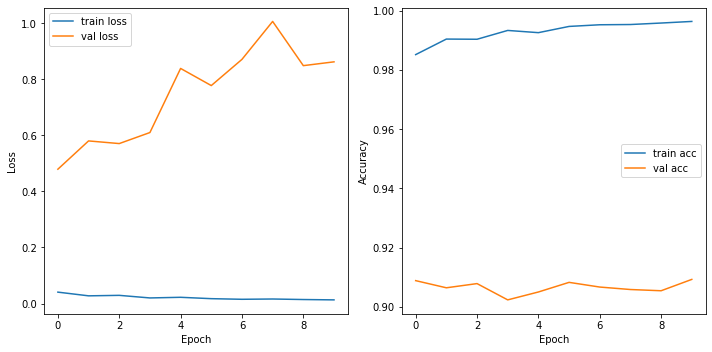

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(model_best_history.history['loss'], label='train loss')
plt.plot(model_best_history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(model_best_history.history['accuracy'], label='train acc')
plt.plot(model_best_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
"""
#save the trained model as a h5 file
model.save('sample_data/model_fashion_mnist.h5')
"""

In [ ]:
"""
#load the trained model
trained_model = keras.models.load_model('sample_data/model_fashion_mnist.h5')
trained_model.summary()
"""

#Testing Phase

In [ ]:
#prediction
pred = model_best.predict(X_test)
pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.5730549e-38,
        4.8013496e-38, 1.0000000e+00],
       [1.4094624e-15, 1.2029533e-31, 1.0000000e+00, ..., 4.5440010e-25,
        9.4227394e-30, 1.7328981e-26],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.3212700e-18, 2.2001480e-15, 5.6161602e-20, ..., 4.8607919e-19,
        3.5084297e-12, 4.2674460e-15]], dtype=float32)

In [ ]:
#get the maximum probability index
pred = np.argmax(pred, axis=1)
pred

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
#testing accuracy
accuracy_score(Y_test, pred)

0.9041